In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import numpy as np
from scipy.stats import chi2_contingency
import glob

# Result visualization

In [3]:
cwd = os.getcwd()
n = 100 # nb of random partitions
k = 5000 # nb of max top_k_edges selected
m = 10 # numer of iterations on confounder-based partitions
ct_sels = ['STAD', 'LUSC'] # string identifiers of cohorts
confs = ['age', 'sex', 'stage'] # string identifiers of confounders/variables
algs = ['ARACNE', 'CEMI', 'GENIE3', 'GRNBOOST2', 'WGCNA'] # string identifiers of algorithms

### Read data from Jaccard Indices for all tools, confounders, cohorts and partition types

In [5]:
JI_conf = pd.DataFrame(columns = ['confounder', 'cohort', 'algorithm', 'partType', 'partID', 'k', 'mean JI'])
rnd_counter = 0
conf_counter = 0
for partType in ['conf', 'rnd']:
    for alg_sel in algs:
        for conf_sel in confs:
            for ct_sel in ct_sels:
                try:
                    path = os.path.join(cwd, alg_sel, 'JI_'+str(alg_sel)+'_'+str(ct_sel))
                except:
                    print('no path for ' +str(alg_sel) + str(conf_sel)+str(ct_sel))
                for i in range(n):
                    if partType == 'conf' and i < m:
                        filename = 'cb'+'_'+str(i)+'_'+alg_sel+'_'+conf_sel+'_'+ct_sel+'_jaccInd.csv'
                        try:
                            df = pd.read_csv(os.path.join(path, filename), sep=',', header=0)
                            conf_counter += 1
                            df['partID'] = i
                            df['partType'] = partType
                            df['algorithm'] = alg_sel
                            df['cohort'] = ct_sel
                            df['confounder'] = conf_sel
                            JI_conf = pd.concat([JI_conf, df])
                        except:
                            continue
                    elif partType == 'rnd':
                        filename = 'rnd'+'_'+str(i)+'_'+alg_sel+'_'+conf_sel+'_'+ct_sel+'_jaccInd.csv'
                        try:
                            df = pd.read_csv(os.path.join(path, filename), sep=',', header=0)
                            rnd_counter += 1
                            df['partID'] = i
                            df['partType'] = partType
                            df['algorithm'] = alg_sel
                            df['cohort'] = ct_sel
                            df['confounder'] = conf_sel
                            JI_conf = pd.concat([JI_conf, df])
                        except:
                            continue
                    else:
                        continue

print(JI_conf.head())
print('number of rows corresponding to random partitions:' + str(rnd_counter))
print('number of rows corresponding to confounder-based partitions:' + str(conf_counter))

  confounder cohort algorithm partType partID    k   mean JI  \
0        age   STAD    ARACNE     conf      0   10  0.176471   
1        age   STAD    ARACNE     conf      0   60  0.188119   
2        age   STAD    ARACNE     conf      0  110  0.176471   
3        age   STAD    ARACNE     conf      0  160  0.180812   
4        age   STAD    ARACNE     conf      0  210  0.179775   

   size intersection  size union      state  
0                3.0        17.0  filled01_  
1               19.0       101.0  filled01_  
2               33.0       187.0  filled01_  
3               49.0       271.0  filled01_  
4               64.0       356.0  filled01_  
number of rows corresponding to random partitions:1900
number of rows corresponding to confounder-based partitions:190


In [6]:
JI_all_type = JI_conf.copy()
JI_all_type['confounder'] = JI_all_type['confounder'].replace(['race'], 'ethnicity')
JI_all_type['partType'] = JI_all_type['partType'].replace(['rnd'], 'random')
JI_all_type['partType'] = JI_all_type['partType'].replace(['conf'], 'confounder-based')
JI_all_type.rename(columns={'partType': 'partition type', 'algorithm':'method'}, inplace=True)
confs = ['sex', 'age']

In [7]:
JI_all = JI_all_type[JI_all_type['k']%100 == 10]

### 1) Plot mean JI over k per cohort and per confounder

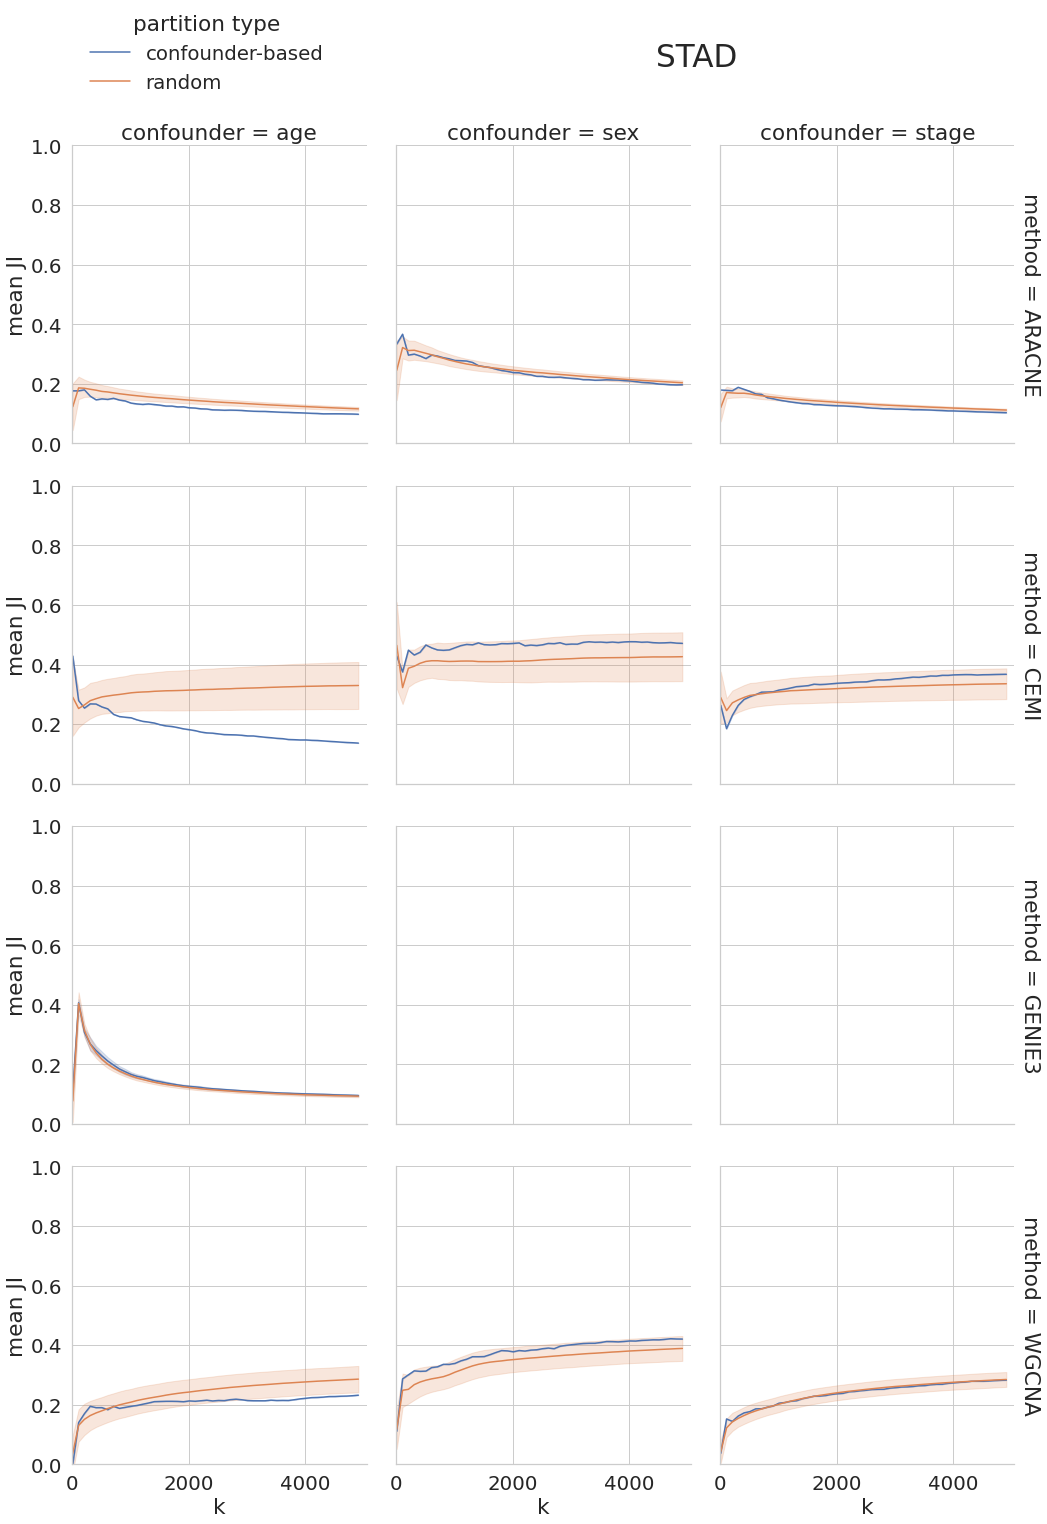

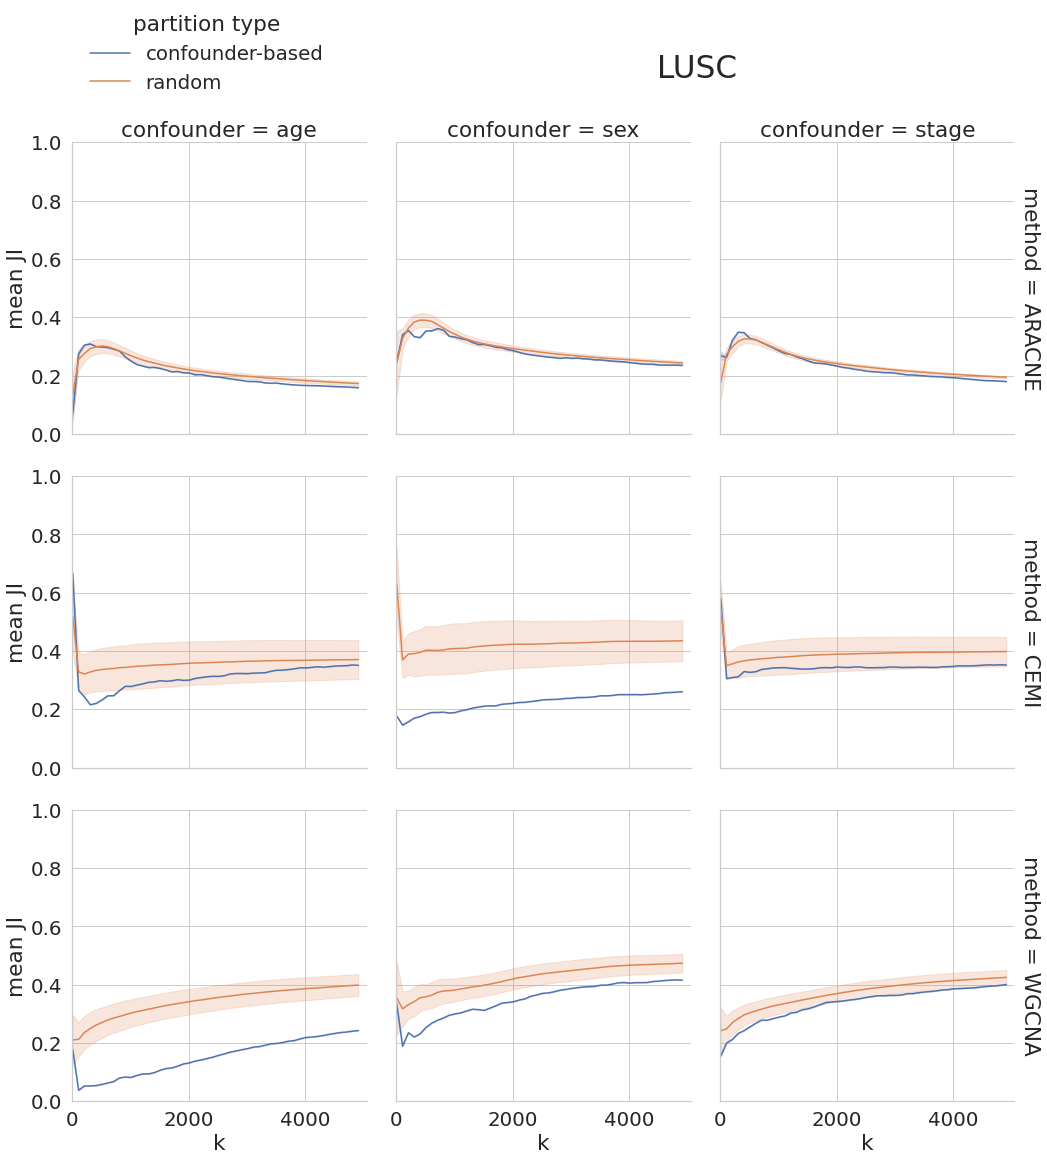

In [12]:
sns.set(font_scale=1.8)
sns.set_style('whitegrid')
for ct_sel in ct_sels:
    JI = JI_all[JI_all['cohort'] == ct_sel]
    g = sns.FacetGrid(JI, row="method", col="confounder", hue='partition type', 
                      margin_titles=True, xlim=(0,5050), ylim=(0,1), legend_out=False, height=5)
    ax = g.axes[0,0]
    g.map(sns.lineplot, "k", "mean JI",errorbar='sd').add_legend()
    g.fig.suptitle(str(ct_sel), y=1.04, x=0.66, fontsize='x-large')
    sns.move_legend(ax, "upper left", frameon=False, bbox_to_anchor=(0.0, 1.5))
    